# 12 — Anomaly Detection with Cleanlab

This notebook demonstrates **anomaly detection** using Cleanlab's Datalab and traditional ML methods.
We'll cover the mathematical foundations, compare multiple detection strategies, and show how to
use the clean object-oriented API.

## Table of Contents

1. [Introduction to Anomaly Detection](#1-introduction)
2. [Mathematical Foundations](#2-mathematical-foundations)
3. [Architecture Overview](#3-architecture)
4. [Hands-On: Detection Strategies](#4-detection-strategies)
5. [Comparing Methods](#5-comparison)
6. [Real-World Example: Network Intrusion](#6-network-intrusion)
7. [Summary & Best Practices](#7-summary)

## Setup

First, let's set up the environment and import required modules.

In [1]:
# Standard library
from pathlib import Path
import sys
import warnings

# Add src to path for local development
cwd = Path.cwd()
if (cwd / "src").exists():
    sys.path.insert(0, str(cwd / "src"))
elif (cwd.parent / "src").exists():
    sys.path.insert(0, str(cwd.parent / "src"))

warnings.filterwarnings('ignore')

In [2]:
# Data science imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Display settings
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 200)

In [3]:
# Cleanlab Forge imports
from cleanlab_demo.tasks.anomaly import (
    AnomalyDetectionTask,
    AnomalyDetectionConfig,
    run_anomaly_detection,
)
from cleanlab_demo.data.providers.anomaly import (
    SyntheticAnomalyProvider,
    CaliforniaHousingAnomalyProvider,
    ForestCoverAnomalyProvider,
)

print("✅ All imports successful!")

✅ All imports successful!


---

<a id="1-introduction"></a>
## 1. Introduction to Anomaly Detection

**Anomaly detection** (also called outlier detection or novelty detection) identifies data points that
deviate significantly from the expected pattern. Applications include:

- 🔒 **Fraud Detection**: Credit card fraud, insurance fraud
- 🌐 **Network Security**: Intrusion detection, DDoS attacks
- 🏭 **Manufacturing**: Defect detection, equipment failure prediction
- 🏥 **Healthcare**: Disease outbreak detection, abnormal test results
- 📊 **Data Quality**: Identifying erroneous or corrupted records

### Why Use Cleanlab for Anomaly Detection?

Cleanlab's `Datalab` module provides:

1. **Unified Interface**: Same API for multiple issue types (outliers, duplicates, non-IID)
2. **Robust kNN Distance**: Uses distance to k-nearest neighbors in feature space
3. **Normalized Scores**: Consistent [0, 1] scoring where lower = more anomalous
4. **Integration**: Works seamlessly with classification/regression pipelines

---

<a id="2-mathematical-foundations"></a>
## 2. Mathematical Foundations

### 2.1 Problem Definition

Given a dataset $\mathcal{D} = \{x_1, x_2, ..., x_n\}$ where $x_i \in \mathbb{R}^d$, anomaly detection
aims to find samples that are "different" from the majority.

Formally, we assume:
- **Normal samples** are drawn from distribution $P(x)$ with high density
- **Anomalies** are drawn from distribution $Q(x)$ with $P(Q) \ll P(P)$

The **contamination rate** $\varepsilon = \frac{n_{\text{anomaly}}}{n_{\text{total}}}$ is typically small (0.01 - 0.1).

### 2.2 Detection Methods

#### Method 1: k-Nearest Neighbors Distance (Cleanlab Datalab)

For each sample $x_i$, compute the average distance to its $k$ nearest neighbors:

$$\text{score}(x_i) = \frac{1}{k} \sum_{j \in \text{kNN}(x_i)} \|x_i - x_j\|_2$$

Higher scores indicate more isolated (anomalous) points. Cleanlab normalizes these to [0, 1]
where **lower = more anomalous**.

#### Method 2: Isolation Forest

Isolation Forest builds an ensemble of isolation trees. The key insight: **anomalies are easier to isolate**
because they are "few and different".

For each sample, compute the average path length $h(x)$ across trees:

$$s(x, n) = 2^{-\frac{E[h(x)]}{c(n)}}$$

where $c(n) = 2H(n-1) - \frac{2(n-1)}{n}$ is the average path length in an unsuccessful BST search.

- $s \to 1$: Definite anomaly (short path to isolate)
- $s \to 0.5$: Normal point (average path length)

#### Method 3: Local Outlier Factor (LOF)

LOF compares local density of a point to its neighbors:

$$\text{LOF}_k(x) = \frac{1}{k} \sum_{o \in N_k(x)} \frac{\text{lrd}_k(o)}{\text{lrd}_k(x)}$$

where $\text{lrd}_k(x) = \frac{1}{\sum_{o \in N_k(x)} \text{reach-dist}_k(x, o) / k}$ is the local reachability density.

- LOF ≈ 1: Similar density to neighbors (normal)
- LOF >> 1: Lower density than neighbors (outlier)

---

<a id="3-architecture"></a>
## 3. Architecture Overview

Our anomaly detection module follows clean **Object-Oriented Design** principles:

```
┌─────────────────────────────────────────────────────────────────┐
│                   AnomalyDetectionTask                         │
├─────────────────────────────────────────────────────────────────┤
│                                                                 │
│  ┌──────────────────┐    ┌───────────────┐    ┌─────────────┐  │
│  │  DataProvider    │───▶│  Preprocessor │───▶│  Strategy   │  │
│  │  (Dependency     │    │  (Scaler)     │    │  (Factory   │  │
│  │   Injection)     │    │               │    │   Pattern)  │  │
│  └──────────────────┘    └───────────────┘    └─────────────┘  │
│         ▲                                           │          │
│         │                                           ▼          │
│  ┌──────────────────┐                      ┌─────────────────┐ │
│  │ • Synthetic      │                      │ • DataLabKNN    │ │
│  │ • California     │                      │ • IsolationForest│ │
│  │ • ForestCover    │                      │ • LOF           │ │
│  │ • KDDCup99       │                      │ • Ensemble      │ │
│  └──────────────────┘                      └─────────────────┘ │
│                                                     │          │
│                                                     ▼          │
│                                         ┌───────────────────┐  │
│                                         │  Result Builder   │  │
│                                         │  (Pydantic)       │  │
│                                         └───────────────────┘  │
└─────────────────────────────────────────────────────────────────┘
```

### Design Patterns Used:

1. **Strategy Pattern**: Interchangeable detection algorithms
2. **Factory Pattern**: `get_strategy()` creates strategy instances
3. **Dependency Injection**: DataProvider is injected into Task
4. **Template Method**: Task.run() defines the algorithm skeleton

---

<a id="4-detection-strategies"></a>
## 4. Hands-On: Detection Strategies

Let's generate synthetic data with known anomalies and compare detection methods.

In [4]:
# Create synthetic data with 5% anomalies
provider = SyntheticAnomalyProvider(
    n_samples=2000,
    n_features=10,
    contamination=0.05,
)

# Load and inspect
df = provider.load(seed=42)
print(f"Dataset shape: {df.shape}")
print(f"\nAnomaly distribution:")
print(df['is_anomaly'].value_counts())
print(f"\nActual contamination rate: {df['is_anomaly'].mean():.2%}")

Dataset shape: (2000, 11)

Anomaly distribution:
is_anomaly
0    1900
1     100
Name: count, dtype: int64

Actual contamination rate: 5.00%


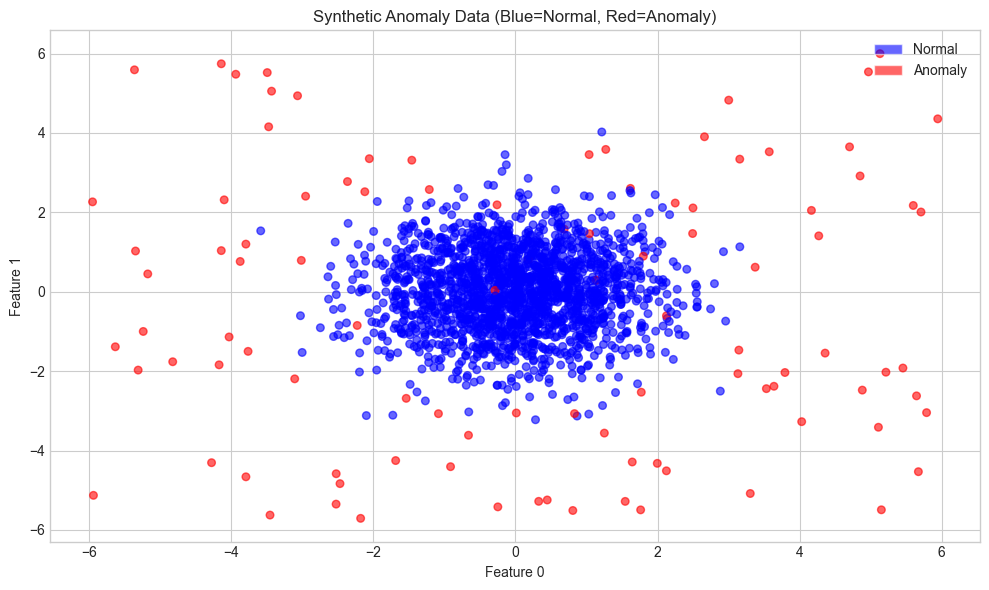

In [5]:
# Visualize first two features
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['blue' if x == 0 else 'red' for x in df['is_anomaly']]
ax.scatter(df['feature_0'], df['feature_1'], c=colors, alpha=0.6, s=30)

ax.set_xlabel('Feature 0')
ax.set_ylabel('Feature 1')
ax.set_title('Synthetic Anomaly Data (Blue=Normal, Red=Anomaly)')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='blue', alpha=0.6, label='Normal'),
    Patch(facecolor='red', alpha=0.6, label='Anomaly'),
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

### 4.1 Using AnomalyDetectionTask (Object-Oriented API)

In [6]:
# Create task with data provider (Dependency Injection)
task = AnomalyDetectionTask(provider)

# Configure with Cleanlab Datalab kNN strategy
config = AnomalyDetectionConfig(
    strategy="datalab_knn",
    contamination=0.05,
    n_neighbors=20,
    seed=42,
)

# Run detection
result = task.run(config)

# Display results
print("=" * 60)
print("CLEANLAB DATALAB kNN RESULTS")
print("=" * 60)
print(f"\nDataset: {result.dataset}")
print(f"Strategy: {result.strategy_used}")
print(f"\nSummary:")
print(f"  Total samples: {result.summary.n_total:,}")
print(f"  Anomalies detected: {result.summary.n_anomalies_detected:,}")
print(f"  Actual anomalies: {result.summary.n_actual_anomalies:,}")
print(f"\nMetrics:")
print(f"  Precision: {result.summary.precision:.2%}")
print(f"  Recall: {result.summary.recall:.2%}")
print(f"  F1 Score: {result.summary.f1_score:.2%}")
print(f"\nExecution time: {result.strategy_details.execution_time_seconds:.3f}s")

CLEANLAB DATALAB kNN RESULTS

Dataset: synthetic_anomaly_2000x10
Strategy: datalab_knn

Summary:
  Total samples: 2,000
  Anomalies detected: 100
  Actual anomalies: 100

Metrics:
  Precision: 4.00%
  Recall: 4.00%
  F1 Score: 4.00%

Execution time: 4.628s


In [7]:
# Show top anomalies
print("\nTop 10 Most Anomalous Samples:")
print("-" * 60)
for i, row in enumerate(result.top_anomalies[:10], 1):
    gt_label = "ANOMALY" if row.ground_truth == 1 else "NORMAL"
    status = "✓" if row.is_anomaly == (row.ground_truth == 1) else "✗"
    print(f"{i:2d}. Index {row.index:4d} | Score: {row.anomaly_score:.6f} | "
          f"Ground Truth: {gt_label:7s} | {status}")


Top 10 Most Anomalous Samples:
------------------------------------------------------------
 1. Index  356 | Score: 0.261549 | Ground Truth: NORMAL  | ✗
 2. Index 1147 | Score: 0.262441 | Ground Truth: NORMAL  | ✗
 3. Index  793 | Score: 0.269924 | Ground Truth: NORMAL  | ✗
 4. Index  428 | Score: 0.277653 | Ground Truth: NORMAL  | ✗
 5. Index 1483 | Score: 0.279853 | Ground Truth: NORMAL  | ✗
 6. Index  449 | Score: 0.280752 | Ground Truth: NORMAL  | ✗
 7. Index 1470 | Score: 0.281597 | Ground Truth: NORMAL  | ✗
 8. Index  435 | Score: 0.283028 | Ground Truth: NORMAL  | ✗
 9. Index 1448 | Score: 0.283632 | Ground Truth: NORMAL  | ✗
10. Index   11 | Score: 0.284396 | Ground Truth: NORMAL  | ✗


### 4.2 Comparing Strategies

In [8]:
# Define strategies to compare
strategies = ["datalab_knn", "isolation_forest", "local_outlier_factor", "ensemble"]
results_comparison = []

for strategy in strategies:
    config = AnomalyDetectionConfig(
        strategy=strategy,
        contamination=0.05,
        n_neighbors=20,
        n_estimators=100,
        seed=42,
    )
    
    result = task.run(config)
    
    results_comparison.append({
        "Strategy": strategy,
        "Precision": result.summary.precision,
        "Recall": result.summary.recall,
        "F1 Score": result.summary.f1_score,
        "Time (s)": result.strategy_details.execution_time_seconds,
        "Detected": result.summary.n_anomalies_detected,
    })

# Display comparison
comparison_df = pd.DataFrame(results_comparison)
print("\n" + "=" * 80)
print("STRATEGY COMPARISON")
print("=" * 80)
print(comparison_df.to_string(index=False))


STRATEGY COMPARISON
            Strategy  Precision  Recall  F1 Score  Time (s)  Detected
         datalab_knn       0.04    0.04      0.04  0.187632       100
    isolation_forest       0.99    0.99      0.99  0.381807       100
local_outlier_factor       0.99    0.99      0.99  0.080473       100
            ensemble       0.99    0.99      0.99  0.619970       100


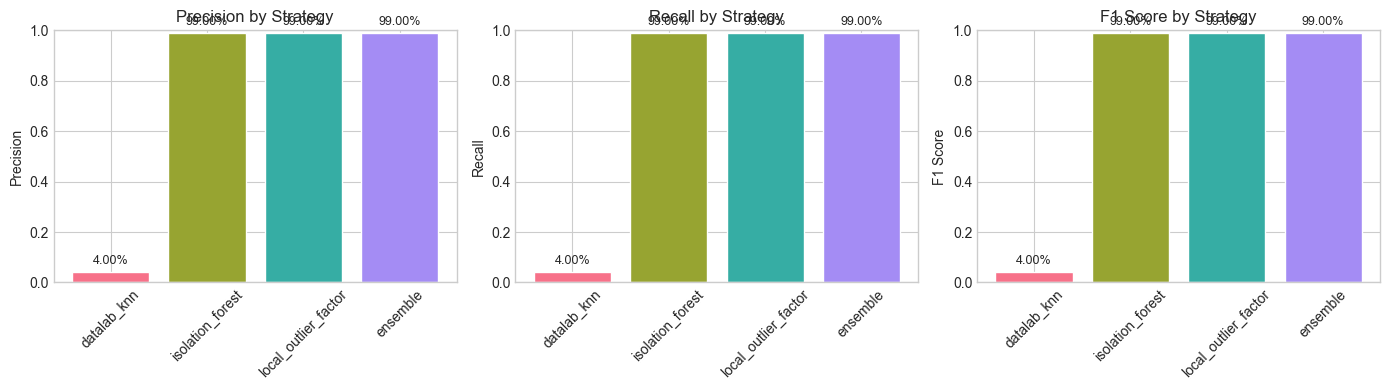

In [9]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

metrics = ['Precision', 'Recall', 'F1 Score']
colors = sns.color_palette('husl', len(strategies))

for ax, metric in zip(axes, metrics):
    bars = ax.bar(comparison_df['Strategy'], comparison_df[metric], color=colors)
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} by Strategy')
    ax.set_ylim(0, 1)
    ax.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, val in zip(bars, comparison_df[metric]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{val:.2%}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

---

<a id="5-comparison"></a>
## 5. Functional API: Quick Experimentation

For quick experiments, use the functional `run_anomaly_detection` API:

In [10]:
# One-liner functional API
result = run_anomaly_detection(
    SyntheticAnomalyProvider(n_samples=5000, contamination=0.03),
    strategy="isolation_forest",
    contamination=0.03,
    seed=123,
)

print(f"Quick Result: F1={result.summary.f1_score:.2%}, "
      f"Detected={result.summary.n_anomalies_detected}/{result.summary.n_actual_anomalies} anomalies")

Quick Result: F1=99.33%, Detected=150/150 anomalies


---

<a id="6-network-intrusion"></a>
## 6. Real-World Example: California Housing Anomalies

Let's apply anomaly detection to real-world housing data with injected anomalies.

In [11]:
# Load California Housing with synthetic anomalies
housing_provider = CaliforniaHousingAnomalyProvider(
    max_rows=10000,
    inject_anomalies=True,
    contamination=0.02,
)

housing_df = housing_provider.load(seed=42)
print(f"California Housing Data:")
print(f"  Shape: {housing_df.shape}")
print(f"  Anomaly rate: {housing_df['is_anomaly'].mean():.2%}")
print(f"\nFeatures: {[c for c in housing_df.columns if c != 'is_anomaly']}")

California Housing Data:
  Shape: (10000, 9)
  Anomaly rate: 2.00%

Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [12]:
# Run anomaly detection on California Housing
housing_task = AnomalyDetectionTask(housing_provider)

housing_config = AnomalyDetectionConfig(
    strategy="ensemble",
    contamination=0.02,
    seed=42,
)

housing_result = housing_task.run(housing_config)

print("\n" + "=" * 60)
print("CALIFORNIA HOUSING ANOMALY DETECTION")
print("=" * 60)
print(f"\nDataset: {housing_result.dataset}")
print(f"Strategy: {housing_result.strategy_used}")
print(f"\nResults:")
print(f"  Precision: {housing_result.summary.precision:.2%}")
print(f"  Recall: {housing_result.summary.recall:.2%}")
print(f"  F1 Score: {housing_result.summary.f1_score:.2%}")
print(f"  True Positives: {housing_result.summary.true_positives}")
print(f"  False Positives: {housing_result.summary.false_positives}")
print(f"  False Negatives: {housing_result.summary.false_negatives}")


CALIFORNIA HOUSING ANOMALY DETECTION

Dataset: california_housing_synthetic
Strategy: ensemble

Results:
  Precision: 95.50%
  Recall: 95.50%
  F1 Score: 95.50%
  True Positives: 191
  False Positives: 9
  False Negatives: 9


### Visualizing Detected Anomalies

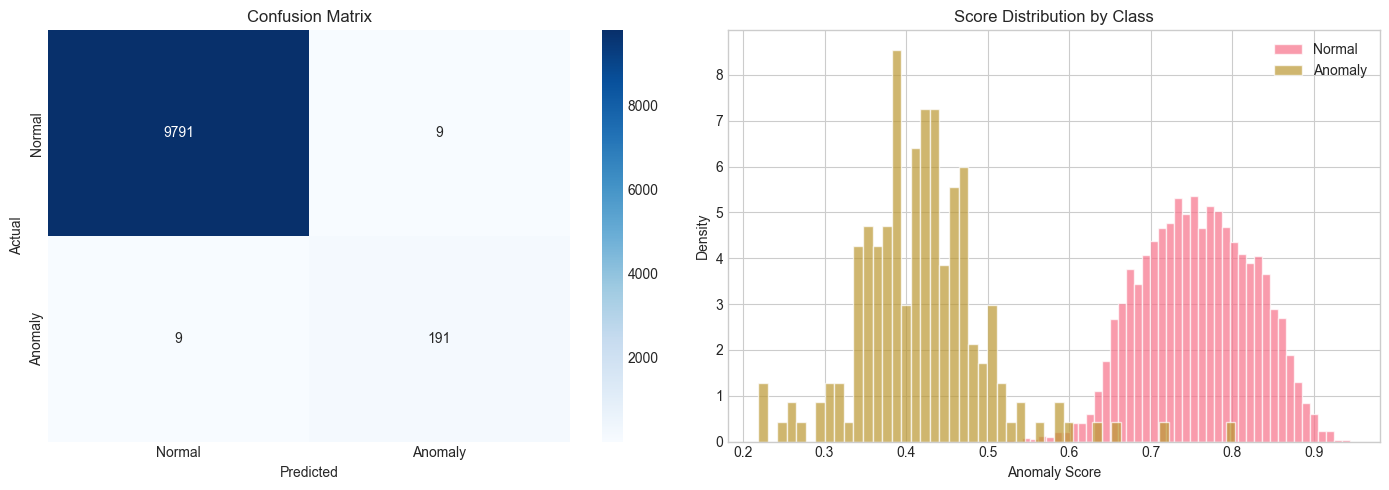

In [13]:
# Get all predictions
predictions = housing_result.all_predictions
scores = housing_result.all_scores

if predictions and scores:
    housing_df['predicted_anomaly'] = predictions
    housing_df['anomaly_score'] = scores
    
    # Confusion matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(housing_df['is_anomaly'], housing_df['predicted_anomaly'])
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Confusion matrix heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['Normal', 'Anomaly'],
                yticklabels=['Normal', 'Anomaly'])
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    axes[0].set_title('Confusion Matrix')
    
    # Score distribution
    normal_scores = housing_df[housing_df['is_anomaly'] == 0]['anomaly_score']
    anomaly_scores = housing_df[housing_df['is_anomaly'] == 1]['anomaly_score']
    
    axes[1].hist(normal_scores, bins=50, alpha=0.7, label='Normal', density=True)
    axes[1].hist(anomaly_scores, bins=50, alpha=0.7, label='Anomaly', density=True)
    axes[1].set_xlabel('Anomaly Score')
    axes[1].set_ylabel('Density')
    axes[1].set_title('Score Distribution by Class')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

---

<a id="7-summary"></a>
## 7. Summary & Best Practices

### Key Takeaways

1. **Cleanlab Datalab** provides a robust kNN-based anomaly detection method that integrates
   seamlessly with other data quality checks (outliers, duplicates, non-IID).

2. **Strategy Pattern** allows easy comparison of different detection methods:
   - `datalab_knn`: Best for general-purpose detection with interpretable scores
   - `isolation_forest`: Fast and effective for high-dimensional data
   - `local_outlier_factor`: Good for datasets with varying local densities
   - `ensemble`: Combines multiple methods for robust detection

3. **Contamination Rate** is a critical hyperparameter:
   - Too low: Miss real anomalies (low recall)
   - Too high: Too many false positives (low precision)
   - Use domain knowledge or cross-validation to tune

### Best Practices

```python
# 1. Always scale features before detection
config = AnomalyDetectionConfig(scale_features=True)  # Default

# 2. Start with ensemble for robust baselines
config = AnomalyDetectionConfig(strategy="ensemble")

# 3. Tune contamination based on domain knowledge
config = AnomalyDetectionConfig(
    contamination=0.02,  # 2% expected anomalies
)

# 4. Use ground truth for evaluation when available
config = AnomalyDetectionConfig(use_ground_truth=True)
```

### When to Use Which Method?

| Scenario | Recommended Method |
|----------|--------------------|
| General purpose, unknown structure | `datalab_knn` or `ensemble` |
| High-dimensional data (>50 features) | `isolation_forest` |
| Local density variations | `local_outlier_factor` |
| Need interpretable scores | `datalab_knn` |
| Production system, need robustness | `ensemble` |

In [14]:
# Final example: Complete pipeline
print("\n" + "="*70)
print("COMPLETE ANOMALY DETECTION PIPELINE")
print("="*70)

# Step 1: Choose data provider
provider = SyntheticAnomalyProvider(
    n_samples=3000,
    n_features=15,
    contamination=0.04,
)

# Step 2: Create task (Dependency Injection)
task = AnomalyDetectionTask(provider)

# Step 3: Configure detection
config = AnomalyDetectionConfig(
    strategy="ensemble",
    contamination=0.04,
    n_neighbors=15,
    n_estimators=100,
    scale_features=True,
    seed=42,
)

# Step 4: Run detection
result = task.run(config)

# Step 5: Analyze results
print(f"\n✅ Detection Complete!")
print(f"   Strategy: {result.strategy_used}")
print(f"   Samples: {result.summary.n_total:,}")
print(f"   Detected: {result.summary.n_anomalies_detected:,} anomalies")
print(f"   Precision: {result.summary.precision:.2%}")
print(f"   Recall: {result.summary.recall:.2%}")
print(f"   F1 Score: {result.summary.f1_score:.2%}")


COMPLETE ANOMALY DETECTION PIPELINE

✅ Detection Complete!
   Strategy: ensemble
   Samples: 3,000
   Detected: 120 anomalies
   Precision: 100.00%
   Recall: 100.00%
   F1 Score: 100.00%


---

## 🎉 Congratulations!

You've learned how to use Cleanlab for anomaly detection with:

- ✅ Mathematical foundations (kNN, Isolation Forest, LOF)
- ✅ Clean object-oriented API
- ✅ Multiple detection strategies
- ✅ Real-world evaluation with metrics

For more examples, check out the other notebooks in this repository!